<a href="https://colab.research.google.com/github/Noza8828/artificial-non-intelligence/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Necessary Libraries

In [ ]:
pip install pyspellchecker


     |████████████████████████████████| 2.7MB 5.8MB/s 


In [ ]:
# import libraries

import re
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import string

# import sklearn libraries
# text processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Decomposition
from sklearn.decomposition import PCA, LatentDirichletAllocation

# ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# model selection
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

# scoring
from sklearn.metrics import make_scorer, mean_squared_error, confusion_matrix, classification_report, plot_confusion_matrix

# Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#import tensorflow libraries
#import nltk libraries
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
df = pd.read_csv('all_tweets_final.csv')
df.head()

,Unnamed: 0,content,label,fake
0,0,damn dude! Thats how I know to go in the dark!...,1,1
1,1,Fuck em. Fuck em over with a fucking feather ...,1,1
2,2,did you know I've gone on 2 podcasts so far......,1,1
3,3,Damn man! Damn that store!!!!,1,1
4,4,i have a hj and i have no damn idea why people...,1,1


In [ ]:
df.drop('Unnamed: 0', axis=1, inplace = True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7986 entries, 0 to 7985
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  7986 non-null   object
 1   label    7986 non-null   int64 
 2   fake     7986 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 249.6+ KB


In [ ]:
df.head()

,content,label,fake
0,damn dude! Thats how I know to go in the dark!...,1,1
1,Fuck em. Fuck em over with a fucking feather ...,1,1
2,did you know I've gone on 2 podcasts so far......,1,1
3,Damn man! Damn that store!!!!,1,1
4,i have a hj and i have no damn idea why people...,1,1


In [ ]:
df.duplicated().sum()

22

In [ ]:
df.drop_duplicates(inplace=True, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7964 entries, 0 to 7963
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  7964 non-null   object
 1   label    7964 non-null   int64 
 2   fake     7964 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 186.8+ KB


# 1. Data Cleaning

## 1.1. Remove Punctuations & convert lowercases

In [ ]:
def text_cleaning(text):
    text = text.lower()
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')
    

    return text   

df['content_clean'] = df['content'].apply(text_cleaning)
df.head()

,content,label,fake,content_clean
0,damn dude! Thats how I know to go in the dark!...,1,1,damn dude thats how i know to go in the dark ...
1,Fuck em. Fuck em over with a fucking feather ...,1,1,fuck em fuck em over with a fucking feather ...
2,did you know I've gone on 2 podcasts so far......,1,1,did you know i ve gone on 2 podcasts so far ...
3,Damn man! Damn that store!!!!,1,1,damn man damn that store
4,i have a hj and i have no damn idea why people...,1,1,i have a hj and i have no damn idea why people...


## 1.2. Remove StopWords & Lemmatize

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def remove_stop_words_lemmatize(text):

    # removing stop wrods
    word_tokens = word_tokenize(text)
    text = [w for w in word_tokens if not w in stop_words]

    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word, pos='v') for word in text]

    text = " ".join(text)
    return text

df['content_clean_stop_words_lemma'] =  df['content_clean'].apply(remove_stop_words_lemmatize)
df.head()

,content,label,fake,content_clean,content_clean_stop_words_lemma
0,damn dude! Thats how I know to go in the dark!...,1,1,damn dude thats how i know to go in the dark ...,damn dude thats know go dark sit still see
1,Fuck em. Fuck em over with a fucking feather ...,1,1,fuck em fuck em over with a fucking feather ...,fuck em fuck em fuck feather dick
2,did you know I've gone on 2 podcasts so far......,1,1,did you know i ve gone on 2 podcasts so far ...,know go 2 podcast far would fuck cross lol xd
3,Damn man! Damn that store!!!!,1,1,damn man damn that store,damn man damn store
4,i have a hj and i have no damn idea why people...,1,1,i have a hj and i have no damn idea why people...,hj damn idea people would put joules


# 2. CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['content_clean_stop_words_lemma']).toarray()
y= df['fake'].values

print ('X-shape:', X.shape)
print ('y-shape:', y.shape)

X-shape: (7964, 6934)
y-shape: (7964,)


# 3. EDA

## 3.1. Data Balancing

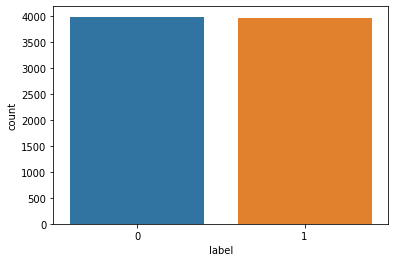

In [ ]:
sns.countplot(data = df, x = 'label')

## 3.2. PCA

In [ ]:
pca = PCA(n_components=1200).fit(X)
X_pca = pca.transform(X)

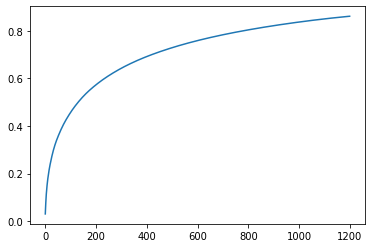

In [ ]:
plt.plot(pca.explained_variance_ratio_.cumsum()) 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


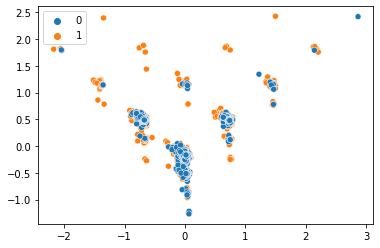

In [ ]:
sns.scatterplot(X_pca[:, 0], X_pca[: ,1], hue=y)

# 4. Model Selection

In [ ]:
df_scores = pd.DataFrame(columns = ['model', 'accuracy', 'precision', 'recall', 'f1_score'])
df_scores

,model,accuracy,precision,recall,f1_score


In [ ]:
X_train, X_test, X_pca_train, X_pca_test, y_train, y_test = train_test_split(X, X_pca, y, test_size = 0.3)

## 4.1. Logistic Regression

In [ ]:
log_reg = LogisticRegression()
model = cross_validate(log_reg, X_pca_train, y_train, cv = 5, verbose=0,  n_jobs=-1, return_estimator=True)
print ('Mean Val Acc:', model['test_score'].mean())

Mean Val Acc: 0.5800156185845055


              precision    recall  f1-score   support

           0       0.58      0.62      0.60      1190
           1       0.59      0.55      0.57      1200

    accuracy                           0.58      2390
   macro avg       0.59      0.59      0.58      2390
weighted avg       0.59      0.58      0.58      2390



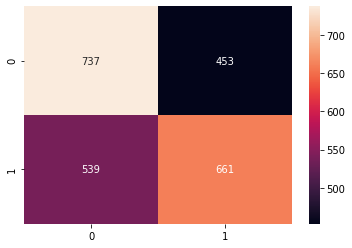

In [ ]:
y_test_pred = log_reg.fit(X_pca_train, y_train).predict(X_pca_test)

print (classification_report(y_test, y_test_pred))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt = 'g')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
precision = round(precision_score(y_test, y_test_pred), 2)
recall    = round(recall_score(y_test, y_test_pred), 2)
f1        = round(f1_score(y_test, y_test_pred), 2)
accuracy = round(accuracy_score(y_test, y_test_pred), 2)
df_scores = df_scores.append(pd.Series(['Logistic Regression', accuracy, precision, recall, f1], index=df_scores.columns), ignore_index=True)
df_scores

,model,accuracy,precision,recall,f1_score
0,Logistic Regression,0.58,0.59,0.55,0.57


## 4.2. Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
model = cross_validate(rf, X_pca_train, y_train, cv = 5, verbose=0,  n_jobs=-1, return_estimator=True)
print ('Mean Val Acc:', model['test_score'].mean())

Mean Val Acc: 0.5810892755070003


              precision    recall  f1-score   support

           0       0.58      0.53      0.56      1190
           1       0.57      0.62      0.59      1200

    accuracy                           0.57      2390
   macro avg       0.58      0.57      0.57      2390
weighted avg       0.58      0.57      0.57      2390



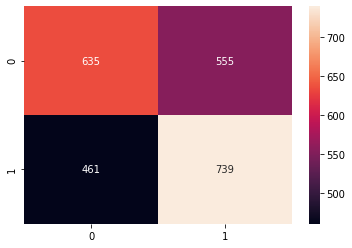

In [ ]:
y_test_pred = rf.fit(X_pca_train, y_train).predict(X_pca_test)

print (classification_report(y_test, y_test_pred))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt = 'g')

In [ ]:
precision = round(precision_score(y_test, y_test_pred), 2)
recall    = round(recall_score(y_test, y_test_pred), 2)
f1        = round(f1_score(y_test, y_test_pred), 2)
accuracy  = round(accuracy_score(y_test, y_test_pred), 2)
df_scores = df_scores.append(pd.Series(['Random Forest', accuracy, precision, recall, f1], index=df_scores.columns), ignore_index=True)
df_scores

,model,accuracy,precision,recall,f1_score
0,Logistic Regression,0.58,0.59,0.55,0.57
1,Random Forest,0.57,0.57,0.62,0.59
2,Random Forest,0.57,0.57,0.62,0.59


## 4.3. MultiNomialNB

In [ ]:
nb_model = MultinomialNB()
model = cross_validate(nb_model, X_train, y_train,  cv = 5, verbose=0,  n_jobs=-1, return_estimator=True)
print ('Mean Val Acc:', model['test_score'].mean())

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Mean Val Acc: 0.5570519519205223


              precision    recall  f1-score   support

           0       0.58      0.38      0.46      1190
           1       0.54      0.72      0.62      1200

    accuracy                           0.55      2390
   macro avg       0.56      0.55      0.54      2390
weighted avg       0.56      0.55      0.54      2390



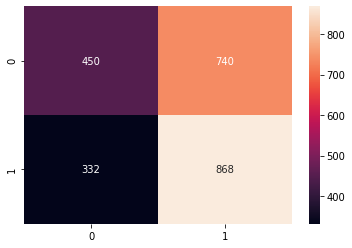

In [ ]:
y_test_pred = nb_model.fit(X_train, y_train).predict(X_test)

print (classification_report(y_test, y_test_pred))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt = 'g')

In [ ]:
precision = round(precision_score(y_test, y_test_pred), 2)
recall    = round(recall_score(y_test, y_test_pred), 2)
f1        = round(f1_score(y_test, y_test_pred), 2)
accuracy  = round(accuracy_score(y_test, y_test_pred), 2)
df_scores = df_scores.append(pd.Series(['MultinomialNB', accuracy, precision, recall, f1], index=df_scores.columns), ignore_index=True)
df_scores

,model,accuracy,precision,recall,f1_score
0,Logistic Regression,0.58,0.59,0.55,0.57
1,Random Forest,0.57,0.57,0.62,0.59
2,Random Forest,0.57,0.57,0.62,0.59
3,MultinomialNB,0.55,0.54,0.72,0.62


## TfidVectorizer

In [ ]:
vectorizer = TfidfVectorizer()
X_Tfid = vectorizer.fit_transform(df['content_clean_stop_words_lemma'].values)

In [ ]:
nb_model = MultinomialNB()
model = cross_validate(nb_model, X_Tfid, y,  cv = 5, verbose=0,  n_jobs=-1, return_estimator=True)
print ('Mean Val Acc:', model['test_score'].mean())

Mean Val Acc: 0.5543694618730817


## 4.4. LatentDirichletAllocation



In [ ]:
lda_model = LatentDirichletAllocation(n_components=2).fit(X_Tfid)

              precision    recall  f1-score   support

           0       0.53      0.44      0.48      3985
           1       0.52      0.60      0.56      3979

    accuracy                           0.52      7964
   macro avg       0.52      0.52      0.52      7964
weighted avg       0.52      0.52      0.52      7964



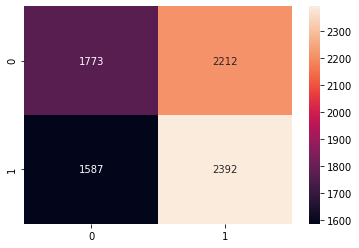

In [ ]:
y_pred = np.argmax(lda_model.transform(X_Tfid), axis=1)
print (classification_report(y, y_pred))
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt = 'g')

# DeepLearning based Models





In [ ]:
df['content'].apply(lambda x: len(x.split())).max()

26

In [ ]:
X = df['content'].values
y = df['fake'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
def strToList(s):
    return s.split()
X_train = [strToList(x) for x in X_train]
X_test = [strToList(x) for x in X_test]

In [ ]:
word_to_id = {}
id = 1
for sentence in X_train:
    for word in sentence:
        if word not in word_to_id:
            word_to_id[word] = id
            id+=1

In [ ]:
X_token_train = []
for sentence in X_train:
    data = []
    for word in sentence:
        data.append(word_to_id[word])
    X_token_train.append(data)

X_token_test = []
for sentence in X_test:
    data = []
    for word in sentence:
        if word in word_to_id:
            data.append(word_to_id[word])
    X_token_test.append(data)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_token_train, dtype='int64',  value = 0)
X_test_pad = pad_sequences(X_token_test, dtype='int64', value = 0)

In [ ]:
print (len(X_token_train))
print (len(X_token_test))
print (X_train_pad.shape)
print (X_test_pad.shape)

5574
2390
(5574, 25)
(2390, 24)


In [ ]:
vocab_size = len(word_to_id)
vocab_size

11550

## 1. LSTM based model

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [ ]:
def init_model(vocab_size):
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size+1, output_dim=200, mask_zero=True))
    model.add(layers.LSTM(units = 32, activation = 'tanh'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])
    return model 

In [ ]:
model = init_model(vocab_size)

es = callbacks.EarlyStopping(patience=4, restore_best_weights = True)
model.fit(X_train_pad, y_train, batch_size=32,
          epochs=10,
          validation_split = 0.1,
          callbacks=[es])

Epoch 1/10
157/157 [==============================] - 16s 74ms/step - loss: 0.6803 - accuracy: 0.5568 - val_loss: 0.6521 - val_accuracy: 0.6541
Epoch 2/10
157/157 [==============================] - 11s 68ms/step - loss: 0.5556 - accuracy: 0.7181 - val_loss: 0.6477 - val_accuracy: 0.6613
Epoch 3/10
157/157 [==============================] - 11s 68ms/step - loss: 0.4165 - accuracy: 0.8036 - val_loss: 0.7737 - val_accuracy: 0.6362
Epoch 4/10
157/157 [==============================] - 11s 69ms/step - loss: 0.3039 - accuracy: 0.8726 - val_loss: 0.8065 - val_accuracy: 0.6201
Epoch 5/10
157/157 [==============================] - 11s 69ms/step - loss: 0.2232 - accuracy: 0.9063 - val_loss: 0.9886 - val_accuracy: 0.6004
Epoch 6/10
157/157 [==============================] - 11s 69ms/step - loss: 0.1681 - accuracy: 0.9330 - val_loss: 1.1753 - val_accuracy: 0.6290


              precision    recall  f1-score   support

           0       0.65      0.54      0.59      1184
           1       0.61      0.71      0.66      1206

    accuracy                           0.63      2390
   macro avg       0.63      0.63      0.62      2390
weighted avg       0.63      0.63      0.62      2390



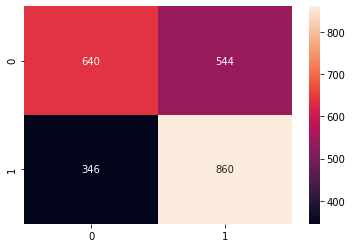

In [ ]:
y_pred = model.predict(X_test_pad)
y_pred = [1 if x > 0.5 else 0 for x in y_pred]
print (classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt = 'g')

In [ ]:
precision = round(precision_score(y_test, y_pred), 2)
recall    = round(recall_score(y_test, y_pred), 2)
f1        = round(f1_score(y_test, y_pred), 2)
accuracy  = round(accuracy_score(y_test, y_pred), 2)
df_scores = df_scores.append(pd.Series(['LSTM', accuracy, precision, recall, f1], index=df_scores.columns), ignore_index=True)
df_scores

,model,accuracy,precision,recall,f1_score
0,Logistic Regression,0.58,0.59,0.55,0.57
1,Random Forest,0.57,0.57,0.62,0.59
2,Random Forest,0.57,0.57,0.62,0.59
3,MultinomialNB,0.55,0.54,0.72,0.62
4,LSTM,0.63,0.61,0.71,0.66


## 1D-CNN based Model

In [ ]:
X_train_pad = pad_sequences(X_token_train, dtype='int64', value = 0, maxlen=26)
X_test_pad = pad_sequences(X_token_test, dtype='int64', value = 0, maxlen=26)

In [ ]:
X_train_pad.shape

(5574, 26)

In [ ]:
X_test_pad.shape

(2390, 26)

In [ ]:
def init_cnn_model(vocab_size):
    ### YOUR CODE HERE
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size+1, input_length=26, output_dim=32, mask_zero=True))
    model.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())

    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])
    return model 
model_cnn = init_cnn_model(vocab_size)

In [ ]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 32)            369632    
_________________________________________________________________
conv1d (Conv1D)              (None, 22, 64)            10304     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                90176     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
es = callbacks.EarlyStopping(patience=4, restore_best_weights = True)
model_cnn.fit(X_train_pad, y_train, batch_size=32,
          epochs=20,
          validation_split = 0.2,
          callbacks=[es])

Epoch 1/20
140/140 [==============================] - 15s 6ms/step - loss: 0.6835 - accuracy: 0.5519 - val_loss: 0.6702 - val_accuracy: 0.5874
Epoch 2/20
140/140 [==============================] - 1s 5ms/step - loss: 0.6201 - accuracy: 0.6609 - val_loss: 0.6430 - val_accuracy: 0.6251
Epoch 3/20
140/140 [==============================] - 1s 5ms/step - loss: 0.4724 - accuracy: 0.7686 - val_loss: 0.7019 - val_accuracy: 0.6072
Epoch 4/20
140/140 [==============================] - 1s 4ms/step - loss: 0.3189 - accuracy: 0.8636 - val_loss: 0.7928 - val_accuracy: 0.6090
Epoch 5/20
140/140 [==============================] - 1s 5ms/step - loss: 0.1896 - accuracy: 0.9251 - val_loss: 0.9914 - val_accuracy: 0.6117
Epoch 6/20
140/140 [==============================] - 1s 5ms/step - loss: 0.1226 - accuracy: 0.9507 - val_loss: 1.1235 - val_accuracy: 0.5937


              precision    recall  f1-score   support

           0       0.59      0.75      0.66      1184
           1       0.67      0.50      0.57      1206

    accuracy                           0.62      2390
   macro avg       0.63      0.62      0.62      2390
weighted avg       0.63      0.62      0.62      2390



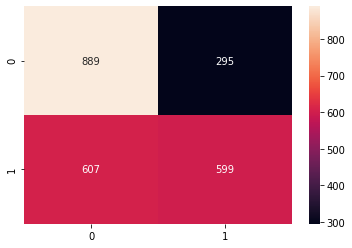

In [ ]:
y_pred = model_cnn.predict(X_test_pad)
y_pred = [1 if x > 0.5 else 0 for x in y_pred]
print (classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt = 'g')

In [ ]:
precision = round(precision_score(y_test, y_pred), 2)
recall    = round(recall_score(y_test, y_pred), 2)
f1        = round(f1_score(y_test, y_pred), 2)
accuracy  = round(accuracy_score(y_test, y_pred), 2)
df_scores = df_scores.append(pd.Series(['1D-CNN', accuracy, precision, recall, f1], index=df_scores.columns), ignore_index=True)
df_scores

,model,accuracy,precision,recall,f1_score
0,Logistic Regression,0.58,0.59,0.55,0.57
1,Random Forest,0.57,0.57,0.62,0.59
2,Random Forest,0.57,0.57,0.62,0.59
3,MultinomialNB,0.55,0.54,0.72,0.62
4,LSTM,0.63,0.61,0.71,0.66
5,1D-CNN,0.62,0.67,0.50,0.57


# Predict Test with Best Model

In [ ]:
df_test = pd.read_csv('merged_tweets.csv')
df_test.dropna(inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    2000 non-null   int64 
 1   content  2000 non-null   object
 2   label    2000 non-null   int64 
 3   fake     2000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 78.1+ KB


In [ ]:
df_test['content_clean'] = df_test['content'].apply(text_cleaning)
df_test.head()

,index,content,label,fake,content_clean
0,0,that sucks :( hope you could see it in her ey...,0,1,that sucks hope you could see it in her ey...
1,1,I hate when my iPhone vibrates off the battery...,0,1,i hate when my iphone vibrates off the battery...
2,2,I know....lol I know...hmm..,0,1,i know lol i know hmm
3,3,how often do the two get together? (hate that!),0,1,how often do the two get together hate that
4,4,What do your dreams have in store for tomorrow?,0,1,what do your dreams have in store for tomorrow


In [ ]:
df_test['content_clean_stop_words_lemma'] =  df_test['content_clean'].apply(remove_stop_words_lemmatize)
df_test.head()

,index,content,label,fake,content_clean,content_clean_stop_words_lemma
0,0,that sucks :( hope you could see it in her ey...,0,1,that sucks hope you could see it in her ey...,suck hope could see eye painful saw dead
1,1,I hate when my iPhone vibrates off the battery...,0,1,i hate when my iphone vibrates off the battery...,hate iphone vibrate battery
2,2,I know....lol I know...hmm..,0,1,i know lol i know hmm,know lol know hmm
3,3,how often do the two get together? (hate that!),0,1,how often do the two get together hate that,often two get together hate
4,4,What do your dreams have in store for tomorrow?,0,1,what do your dreams have in store for tomorrow,dream store tomorrow


In [ ]:
X_train = vectorizer.transform(df['content_clean_stop_words_lemma']).toarray()
y_train = df['fake'].values
X_test = vectorizer.transform(df_test['content_clean_stop_words_lemma']).toarray()
y_test= df_test['fake'].values

              precision    recall  f1-score   support

           0       0.87      0.52      0.65      1000
           1       0.66      0.92      0.77      1000

    accuracy                           0.72      2000
   macro avg       0.76      0.72      0.71      2000
weighted avg       0.76      0.72      0.71      2000



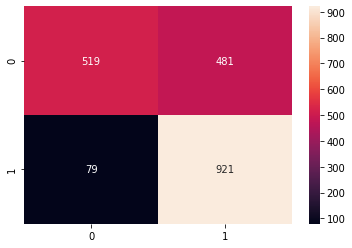

In [ ]:
nb_model = MultinomialNB()
y_test_pred = nb_model.fit(X_train, y_train).predict(X_test)

print (classification_report(y_test, y_test_pred))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt = 'g')

In [ ]:
df_res = df_test[['content', 'label', 'fake']].copy()
df_res['ai_predict'] = y_test_pred
df_res.head()

,content,label,fake,ai_predict
0,that sucks :( hope you could see it in her ey...,0,1,0
1,I hate when my iPhone vibrates off the battery...,0,1,1
2,I know....lol I know...hmm..,0,1,1
3,how often do the two get together? (hate that!),0,1,1
4,What do your dreams have in store for tomorrow?,0,1,1


In [ ]:
df_res.to_csv('ai_predict.csv')